# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [100]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [101]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.common import get_name_15min_chart, get_name_15min_chart_now

## yfinance による株価データの取得

In [102]:
code = "N225"
symbol = f"^{code}"
ticker = yf.Ticker(symbol)
df = ticker.history(period='1d', interval='15m')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-06-02 09:00:00+09:00,37651.179688,37651.179688,37468.210938,37498.250000,0,0.0,0.0
2025-06-02 09:15:00+09:00,37499.050781,37540.910156,37474.621094,37533.460938,0,0.0,0.0
2025-06-02 09:30:00+09:00,37524.468750,37534.769531,37460.359375,37461.921875,0,0.0,0.0
2025-06-02 09:45:00+09:00,37462.449219,37508.261719,37449.121094,37480.718750,0,0.0,0.0
2025-06-02 10:00:00+09:00,37482.871094,37544.898438,37458.218750,37537.988281,0,0.0,0.0
2025-06-02 10:15:00+09:00,37538.839844,37538.941406,37448.890625,37457.191406,0,0.0,0.0
2025-06-02 10:30:00+09:00,37452.218750,37470.621094,37401.148438,37410.179688,0,0.0,0.0
2025-06-02 10:45:00+09:00,37410.218750,37454.859375,37406.230469,37429.910156,0,0.0,0.0
2025-06-02 11:00:00+09:00,37430.281250,37447.570312,37410.070312,37428.300781,0,0.0,0.0


## 前日終値の取得

In [103]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker.history(period='1d', interval='1d', start=str(dt_prev.date()))
n = len(df_last)
lastclose = df_last[n-2:n-1]['Close'].iloc[0]
# 確認のため出力
df_last[n-2:n-1]['Close']

Date
2025-05-30 00:00:00+09:00    37965.101562
Name: Close, dtype: float64

## ローソク足チャート（小さいサイズ）

range of x-axis: (np.float64(-2.0476190476190474), np.float64(22.047619047619047))


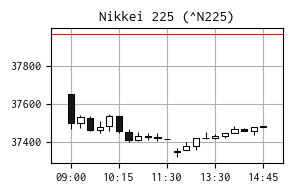

In [104]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 9

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type='candle',
    style='default',
    datetime_format='%H:%M',
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.set_ylabel(None)
ax.grid()

print("range of x-axis:", ax.get_xlim())

if "shortName" in ticker.info:
    ax.set_title(f"{ticker.info['shortName']} ({symbol})")
elif "longName" in ticker.info:
    ax.set_title(f"{ticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")
    
plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()